In [1]:
%matplotlib inline

from os.path import join
import itertools
import threading
import gc

import keras.backend as K
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from keras.optimizers import Nadam, Adam
from keras.models import load_model
from scipy.signal import medfilt

import matplotlib.pyplot as plt

import numpy as np
import cv2

def load_ground_truth():
    with open("./data/train.txt") as f:
        ret = [float(l.strip()) for l in f.readlines()]
    return ret

y = np.array(load_ground_truth())

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[n-1:] /= n
    ret[:n] = a[:n]
    return ret 

def array_to_img(x, data_format='channels_last', scale=True, dtype='float32'):
    """Converts a 3D Numpy array to a PIL Image instance.
    # Arguments
        x: Input Numpy array.
        data_format: Image data format.
            either "channels_first" or "channels_last".
        scale: Whether to rescale image values
            to be within `[0, 255]`.
        dtype: Dtype to use.
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if invalid `x` or `data_format` is passed.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    x = np.asarray(x, dtype=dtype)
    if x.ndim != 3:
        raise ValueError('Expected image array to have rank 3 (single image). '
                         'Got array with shape: %s' % (x.shape,))

    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Invalid data_format: %s' % data_format)

    # Original Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but target PIL image has format (width, height, channel)
    if data_format == 'channels_first':
        x = x.transpose(1, 2, 0)
    if scale:
        x = x + max(-np.min(x), 0)
        x_max = np.max(x)
        if x_max != 0:
            x /= x_max
        x *= 255
    if x.shape[2] == 4:
        # RGBA
        return pil_image.fromarray(x.astype('uint8'), 'RGBA')
    elif x.shape[2] == 3:
        # RGB
        return pil_image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return pil_image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise ValueError('Unsupported channel number: %s' % (x.shape[2],))
        
def img_to_array(img, data_format='channels_last', dtype='float32'):
    """Converts a PIL Image instance to a Numpy array.
    # Arguments
        img: PIL Image instance.
        data_format: Image data format,
            either "channels_first" or "channels_last".
        dtype: Dtype to use for the returned array.
    # Returns
        A 3D Numpy array.
    # Raises
        ValueError: if invalid `img` or `data_format` is passed.
    """
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: %s' % data_format)
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=dtype)
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError('Unsupported image shape: %s' % (x.shape,))
    return x

Using TensorFlow backend.


In [2]:
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Conv3D, MaxPooling3D, ZeroPadding3D
from keras.models import Sequential
from keras.models import Model

# from kerasmodelzoo.utils.data import download_file, load_np_data
# https://github.com/albertomontesg/keras-model-zoo/blob/master/kerasmodelzoo/models/c3d.py
# https://github.com/axon-research/c3d-keras/blob/master/test_model.py
#_C3D_WEIGHTS_URL = 'https://www.dropbox.com/s/ypiwalgtlrtnw8b/c3d-sports1M_weights.h5?dl=1'
# https://github.com/adamcasson/c3d/releases

'''
dim_ordering issue:
- 'th'-style dim_ordering: [batch, channels, depth, height, width]
- 'tf'-style dim_ordering: [batch, depth, height, width, channels]
'''

def get_model(weight_file=None):
    """ Return the Keras model of the network
    """
    model = Sequential()
    input_shape=(16, 112, 112, 3) # l, h, w, c
    model.add(Conv3D(64, (3, 3, 3), activation='relu',
                            padding='same', name='conv1',
                            input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2),
                           padding='valid', name='pool1'))
    # 2nd layer group
    model.add(Conv3D(128, (3, 3, 3), activation='relu',
                            padding='same', name='conv2'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool2'))
    # 3rd layer group
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                            padding='same', name='conv3a'))
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                            padding='same', name='conv3b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool3'))
    # 4th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                            padding='same', name='conv4a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                            padding='same', name='conv4b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool4'))
    # 5th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                            padding='same', name='conv5a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                            padding='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool5'))
    model.add(Flatten())
    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(487, activation='softmax', name='fc8'))
    
    x = Dropout(.5)(model.get_layer('fc7').output)
    x = Dense(1, activation='linear', name='regression')(x)
    model2 = Model(inputs=model.input, outputs=x)
        
    if weight_file is None:
        model.load_weights("./sports1M_weights_tf.h5")
    else:
        model2.load_weights(weight_file)

    #model2.summary()
    return model2

# https://github.com/axon-research/c3d-keras/blob/master/models/get_weights_and_mean.sh
c3d_mean = np.load('c3d_mean.npy')
c3d_mean = np.transpose(c3d_mean, (1, 2, 3, 0))

In [7]:
try:
    from PIL import ImageEnhance
    from PIL import Image as pil_image
except ImportError:
    pil_image = None
    ImageEnhance = None

# https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image.py
def apply_brightness_shift(x, brightness):
    """Performs a brightness shift.
    # Arguments
        x: Input tensor. Must be 3D.
        brightness: Float. The new brightness value.
        channel_axis: Index of axis for channels in the input tensor.
    # Returns
        Numpy image tensor.
    # Raises
        ValueError if `brightness_range` isn't a tuple.
    """
    if ImageEnhance is None:
        raise ImportError('Using brightness shifts requires PIL. '
                          'Install PIL or Pillow.')
    x = array_to_img(x)
    x = imgenhancer_Brightness = ImageEnhance.Brightness(x)
    x = imgenhancer_Brightness.enhance(brightness)
    x = img_to_array(x)
    return x

class InputGenerator(object):
    def __init__(self, X, Y=None, sample_weight=None, mean=None,
                 brightness_range=None, random_crop=False,
                 shuffle=False, batch_size=32, random_state=None):
        self.X = X
        self.Y = Y
        self.lock = threading.Lock()
        if random_state is None:
            self.random_state = np.random.RandomState()
        self.index_generator = self._flow_index(X.shape[0], batch_size, shuffle,
                self.random_state)
        self.sample_weight = sample_weight
        self.mean = mean
        self.batch_size = batch_size
        self.brightness_range = brightness_range
        self.random_crop = random_crop
        
    def __len__(self):
        return (((self.X.shape[0]-16) - 1) // self.batch_size) + 1

    def __iter__(self):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)

    def _flow_index(self, n, batch_size, shuffle, random_state):
        index = np.arange(8, n-8)
        for epoch_i in itertools.count():
            if shuffle:
                random_state.shuffle(index)
            for batch_start in range(0, n-16, batch_size):
                batch_end = min(batch_start + batch_size, n)
                yield epoch_i, index[batch_start: batch_end]

    def next(self):
        with self.lock:
            _, index_array = next(self.index_generator)
        batch_X = []
        for i in index_array:
            batch_x = self.X[np.arange(i-8, i+8)] - self.mean
            img_width, img_height = self.X[0].shape[:2]
            if self.random_crop:
                start_y = int(np.round((img_height - 112) * self.random_state.rand()))
                start_x = int(np.round((img_width - 112) * self.random_state.rand()))
            else:
                start_y = (img_height - 112) // 2
                start_x = (img_width - 112) // 2
            batch_x = batch_x[:, start_x:(112 + start_x), start_y:(112 + start_y), :]
            
            if self.brightness_range is not None:
                u = self.random_state.uniform(self.brightness_range[0], self.brightness_range[1])
                temp = []
                for x in batch_x:
                    temp.append(apply_brightness_shift(x, u)[np.newaxis, :, :, :])
                batch_x = np.concatenate(temp, axis=0)
            
            batch_X.append(batch_x)
        batch_X = np.array(batch_X, dtype=np.float32)
        #print(batch_X.shape)

        if self.Y is None:
            return batch_X
        else:
            batch_Y = self.Y[index_array]
            if self.sample_weight is not None:
                batch_weight = self.sample_weight[index_array]
                return batch_X, batch_Y, batch_weight
            else:
                return batch_X, batch_Y
            
            
def pred_seq(X, model):
    generator = InputGenerator(X, mean=c3d_mean, batch_size=batch_size, shuffle=False)
    pred = model.predict_generator(generator, steps=len(generator), verbose=1)
    pred = np.concatenate((np.ones(8)*pred[0][0], pred.reshape(-1), np.ones(8)*pred[-1][0]))
    return pred

def evaluation(X, y, model):
    pred = pred_seq(X, model)
    return mean_squared_error(y, pred)

batch_size = 16

In [4]:
%%time
# load training data
X = []
for i in range(20400):
    img = cv2.imread(join("/tmp/frames/train/", f"{i+1:08d}.png"), 1)
    X.append(cv2.resize(img, (171, 128)))
X = np.array(X, dtype=np.float32)

CPU times: user 1min 39s, sys: 7.44 s, total: 1min 46s
Wall time: 1min 46s


## Test with validation data

In [ ]:
# fix weight
c3d_model = get_model()
for i in range(14):
    c3d_model.layers[i].trainable = False
#optimizer = Nadam()
optimizer = Adam(lr=1e-5)
c3d_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [27]:
#c3d_model = load_model("./weights/c3d-12-4.39.hdf5")
batch_size = 16
trn_gen = InputGenerator(X[:18000], y[:18000], mean=c3d_mean,
                         batch_size=batch_size,
                         shuffle=True, brightness_range=(0.3, 1.0),
                         random_crop=True)
val_gen = InputGenerator(X[18000:], y[18000:], mean=c3d_mean, batch_size=batch_size)

checkpoint_callback = ModelCheckpoint("./weights/c3d-{epoch:02d}-{val_loss:.2f}.hdf5")

c3d_model.fit_generator(
    trn_gen,
    steps_per_epoch=len(trn_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    max_queue_size=50,
    workers=8,
    epochs=10,
    use_multiprocessing=False,
    initial_epoch=0,
    callbacks=[checkpoint_callback],
)

In [13]:
pred_trn = pred_seq(X[:18000], c3d_model)
pred_val = pred_seq(X[18000:], c3d_model)
print("trn err: ", mean_squared_error(y[:18000], pred_trn))
print("val err: ", mean_squared_error(y[18000:], pred_val))

149/149 [==============================] - 32s 218ms/step
trn err:  5.761592853797788
val err:  1.8247298461861332


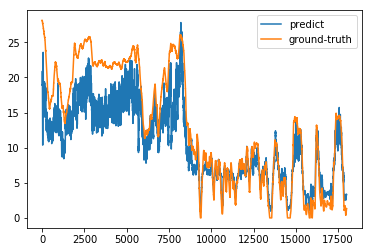

In [17]:
plt.plot(pred_trn, label="predict")
plt.plot(y[:18000], label="ground-truth")
plt.legend()

trn err:  18.327962066045362


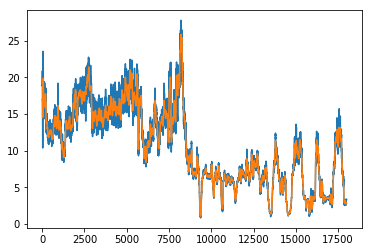

In [28]:
plt.plot(pred_trn)
plt.plot(medfilt(pred_trn, 39))
print("trn err: ", mean_squared_error(y[:18000], medfilt(pred_trn, 39)))

## Try with finetuning the CNN layers

In [ ]:
# finetune with smaller learning rate
gc.collect()
K.clear_session()
c3d_model = get_model("./weights/c3d-15-4.75.hdf5")

for i in range(14):
    c3d_model.layers[i].trainable = True
optimizer = Adam(lr=1e-8)
c3d_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
batch_size = 16
trn_gen = InputGenerator(X[[:18000]], y[:18000], mean=c3d_mean, batch_size=batch_size,
                         shuffle=True, brightness_range=(0.3, 1.0), random_crop=True)
val_gen = InputGenerator(X[18000:], y[18000:], mean=c3d_mean, batch_size=batch_size)

checkpoint_callback = ModelCheckpoint("./weights/c3d_fintune-{epoch:02d}-{val_loss:.2f}.hdf5")

c3d_model.fit_generator(
    trn_gen,
    steps_per_epoch=len(trn_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    max_queue_size=50,
    workers=6,
    epochs=5,
    initial_epoch=0,
    use_multiprocessing=False,
    callbacks=[checkpoint_callback],
)

In [7]:
pred_trn = pred_seq(X[:18000], c3d_model)
pred_val = pred_seq(X[18000:], c3d_model)
print("trn err: ", mean_squared_error(y[:18000], pred_trn))
print("val err: ", mean_squared_error(y[18000:], pred_val))

149/149 [==============================] - 31s 207ms/step
trn err:  16.72009873735098
val err:  4.752842675178797


In [14]:
print("trn err: ", mean_squared_error(y[:18000], moving_average(pred_trn, n=20)))
print("val err: ", mean_squared_error(y[18000:], moving_average(pred_val, n=10)))

trn err:  16.193875199234835
val err:  4.555245159257686


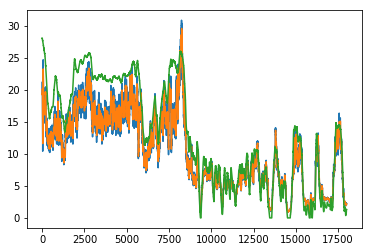

In [13]:
plt.plot(pred_trn)
plt.plot(moving_average(pred_trn, n=10))
plt.plot(y[:18000])

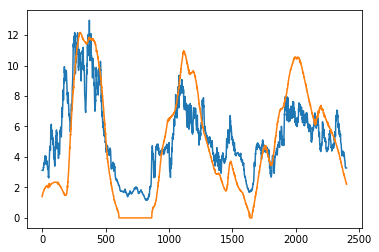

In [9]:
plt.plot(pred_val)
plt.plot(y[18000:])

In [12]:
pred_trn = pred_seq(X, c3d_model)
print("trn err: ", mean_squared_error(y, pred_trn))
print("moving avg trn err: ", mean_squared_error(y, moving_average(pred_trn, n=20)))

1274/1274 [==============================] - 276s 216ms/step
trn err:  29.63680318771792
moving avg trn err:  29.374796719319757


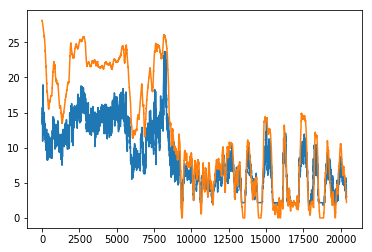

In [13]:
plt.plot(pred_trn)
plt.plot(y)

## After analysis, train with full dataset

In [9]:
# fix weight
#c3d_model = get_model()
#for i in range(14):
#    c3d_model.layers[i].trainable = False
##optimizer = Nadam()
#optimizer = Adam(lr=1e-5)
#c3d_model.compile(optimizer=optimizer, loss='mean_squared_error')

c3d_model = load_model("./weights/full2-c3d-20-0.51.hdf5")
K.set_value(c3d_model.optimizer.lr, 1e-6)

batch_size = 16
trn_gen = InputGenerator(X, y, mean=c3d_mean, batch_size=batch_size,
                         shuffle=True, brightness_range=(0.3, 1.0),
                         random_crop=True)

checkpoint_callback = ModelCheckpoint("./weights/full2-c3d-{epoch:02d}-{loss:.2f}.hdf5")

c3d_model.fit_generator(
    trn_gen,
    steps_per_epoch=len(trn_gen),
    max_queue_size=50,
    workers=8,
    epochs=25,
    initial_epoch=20,
    use_multiprocessing=False,
    callbacks=[checkpoint_callback],
)

Epoch 21/25
1274/1274 [==============================] - 326s 256ms/step - loss: 0.4456
Epoch 22/25
1274/1274 [==============================] - 312s 245ms/step - loss: 0.4248
Epoch 23/25
1274/1274 [==============================] - 311s 244ms/step - loss: 0.3965
Epoch 24/25
1274/1274 [==============================] - 307s 241ms/step - loss: 0.3855
Epoch 25/25
1274/1274 [==============================] - 307s 241ms/step - loss: 0.3783


In [10]:
pred_trn = pred_seq(X, c3d_model)
print("trn err: ", mean_squared_error(y, pred_trn))
print("moving avg trn err: ", mean_squared_error(y, moving_average(pred_trn, n=20)))

1274/1274 [==============================] - 273s 214ms/step
trn err:  3.640995019001178
moving avg trn err:  3.593970187431911


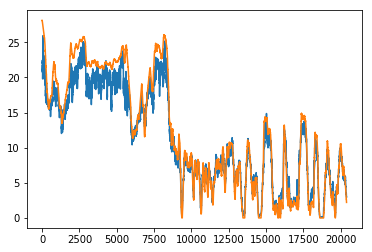

In [11]:
plt.plot(pred_trn)
plt.plot(y)

In [21]:
def pred_and_plot(model_path):
    c3d_model = load_model(model_path)
    pred_trn = pred_seq(X, c3d_model)
    print("trn err: ", mean_squared_error(y, pred_trn))
    print("moving avg trn err: ", mean_squared_error(y, moving_average(pred_trn, n=20)))
    plt.plot(pred_trn)
    plt.plot(y)

In [19]:
%%time
# load test frames
tstX = []
for i in range(10798):
    img = cv2.imread(join("/tmp/frames/test/", f"{i+1:08d}.png"), 1)
    tstX.append(cv2.resize(img, (171, 128)))
tstX = np.array(tstX, dtype=np.float32)

CPU times: user 52.3 s, sys: 3.35 s, total: 55.7 s
Wall time: 55.7 s


## Compare 

674/674 [==============================] - 145s 215ms/step


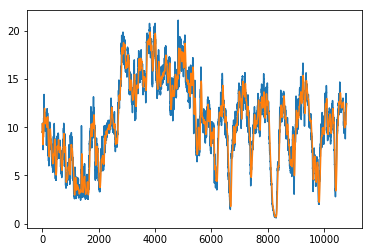

In [20]:
c3d_model = load_model("./weights/full2-c3d-15-0.60.hdf5")
predt = pred_seq(tstX, c3d_model)
plt.plot(predt)
plt.plot(moving_average(predt, 30))

674/674 [==============================] - 144s 214ms/step


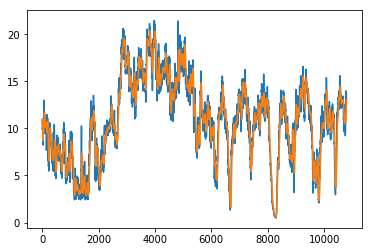

In [21]:
c3d_model = load_model("./weights/full2-c3d-25-0.38.hdf5")
predt = pred_seq(tstX, c3d_model)
plt.plot(predt)
plt.plot(moving_average(predt, 30))

In [22]:
pred = pred_seq(tstX, c3d_model)
pred_tsty = moving_average(pred, 30)
with open("test.txt", "w") as f:
    f.write("\n".join([str(_) for _ in pred_tsty]))

674/674 [==============================] - 144s 214ms/step


In [ ]:
plt.plot(pred)